In [1]:
%pip install torch torchvision matplotlib numpy tqdm scikit-learn

In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = torch.utils.data.DataLoader(
          torchvision.datasets.MNIST('./data', transform=torchvision.transforms.ToTensor(), download=True),
          batch_size=128,
          shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4175990.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 134301.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1082470.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4351422.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        self.mu =  self.linear2(x)
        self.sigma = torch.exp(self.linear3(x))
        z = self.mu + self.sigma*self.N.sample(self.mu.shape)
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), self.encoder.mu, self.encoder.sigma

vae = VariationalAutoencoder(32).to(device)
vae

VariationalAutoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=32, bias=True)
    (linear3): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=32, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [6]:
def loss_function(reconstructed_x, x, mu, sigma):
    reconstructed_x = torch.flatten(reconstructed_x, start_dim=1)
    bce = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    logvar = torch.log(sigma.pow(2))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kl

In [7]:
from tqdm.notebook import tqdm

def train(vae, data, epochs=20):
    try:
        optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4, betas=(0.9, 0.999))
        for epoch in tqdm(range(epochs)):
            avg_loss = 0
            for x, y in data:
                x = x.to(device)
                optimizer.zero_grad()
                out, mu, sigma = vae(x)
                loss = loss_function(out, x, mu, sigma)
                avg_loss += loss.item()
                loss.backward()
                optimizer.step()
            print(f"Epoch: {epoch}, Loss: {avg_loss / len(data)}")
    except KeyboardInterrupt:
        print("Exiting...")

train(vae, data)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Loss: 25729.260702625266
Epoch: 1, Loss: 18377.61342284115
Epoch: 2, Loss: 16681.989101645788
Epoch: 3, Loss: 15782.311640041977
Epoch: 4, Loss: 15227.700830390459
Epoch: 5, Loss: 14870.886985274521
Epoch: 6, Loss: 14612.263611490538
Epoch: 7, Loss: 14412.986696678438
Epoch: 8, Loss: 14253.331858425507
Epoch: 9, Loss: 14127.044166028118
Epoch: 10, Loss: 14027.895718117004
Epoch: 11, Loss: 13941.537690315165
Epoch: 12, Loss: 13867.31212936434
Epoch: 13, Loss: 13802.333143156982
Epoch: 14, Loss: 13748.407742953757
Epoch: 15, Loss: 13697.278799223748
Epoch: 16, Loss: 13653.683658298907
Epoch: 17, Loss: 13619.586239422308
Epoch: 18, Loss: 13582.04611290645
Epoch: 19, Loss: 13547.680699460288


In [8]:
torch.save(vae.state_dict(), 'vae.pth')

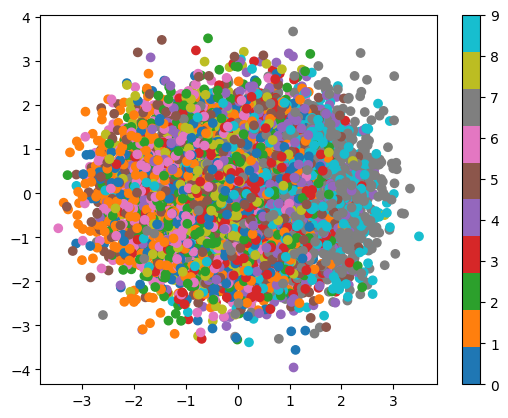

In [9]:
for i, (x, y) in enumerate(data):
    x = x.to(device)
    z = vae.encoder(x)
    z = z.to('cpu').detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
    if i > 100:
        break

plt.colorbar()

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

latent_representations = []
labels = []
for x, y in data:
    x = x.to(device)
    z = vae.encoder(x)
    latent_representations.extend(z.cpu().detach().numpy())
    labels.extend(y.numpy())

latent_representations = np.array(latent_representations)
labels = np.array(labels)


label_sizes = [100, 600, 1000, 3000]

for num_labels in label_sizes:
    sampled_idx = np.random.choice(len(labels), size=num_labels, replace=False)
    X_train_sampled = latent_representations[sampled_idx]
    y_train_sampled = labels[sampled_idx]

    X_train, X_test, y_train, y_test = train_test_split(X_train_sampled, y_train_sampled, test_size=0.2, random_state=123)

    svm_classifier = SVC(kernel='rbf', gamma='scale')
    svm_classifier.fit(X_train, y_train)

    y_pred = svm_classifier.predict(X_test)

    with open(f'svc{num_labels}.pkl','wb') as f:
        pickle.dump(svm_classifier,f)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {num_labels} labels: {accuracy:.4f}")

Accuracy with 100 labels: 0.6500
Accuracy with 600 labels: 0.8667
Accuracy with 1000 labels: 0.8800
Accuracy with 3000 labels: 0.9317


In [13]:
import pickle
from sklearn.metrics import accuracy_score

vae = VariationalAutoencoder(32).to(device)
vae.load_state_dict(torch.load('vae.pth'))

with open('svc3000.pkl', 'rb') as f:
    svm_classifier = pickle.load(f)

for i, (x, y) in enumerate(data):
    x = x.to(device)
    z = vae.encoder(x)
    z = z.cpu().detach().numpy()

    y_pred = svm_classifier.predict(z)

    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    break


Accuracy: 0.9375


<ipython-input-13-d61f26f339e0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('vae.pth'))


# GANs

In [5]:
def weight_initialization(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.normal_(module.weight, 0.0, 0.02)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight, 1.0, 0.02)
        nn.init.constant_(module.bias, 0)

In [28]:
from torch import nn

latent_dims = 100

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        gf = 64
        self.layers = nn.Sequential(
            # +10 for label information (conditional GAN)
            nn.ConvTranspose2d(latent_dims + 10, gf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf*8, gf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf*4, gf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf*2, gf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gf),
            nn.ReLU(True),

            nn.ConvTranspose2d(gf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x)

generator = Generator().to(device)
generator.apply(weight_initialization)
generator

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        df = 64
        self.layers = nn.Sequential(
            nn.Conv2d(1 + 10, df, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(df, df * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(df * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(df * 2, df * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(df * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(df * 4, df * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(df * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(df * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x).view(-1, 1).squeeze(1)

discriminator = Discriminator().to(device)
discriminator.apply(weight_initialization)
discriminator

Discriminator(
  (layers): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [6]:
import torchvision
import torchvision.transforms as transforms

fashion_mnist_data = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data', download=True,
                                      transform=transforms.Compose([
                                          torchvision.transforms.Resize(64),
                                          torchvision.transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                      ])),
    batch_size=128,
    shuffle=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12797287.15it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205282.99it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3718526.11it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23520998.90it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [30]:
from functools import total_ordering
from tqdm.notebook import tqdm

def dcgan_train(discriminator, generator, data, epochs):
    criterion = nn.BCELoss()
    discriminatorOptimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    generatorOptimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    generator_losses = []
    discriminator_losses = []

    try:
        for epoch in tqdm(range(epochs)):
            epoch_generator_loss = 0
            epoch_discriminator_loss = 0
            for i, (x, y) in enumerate(data):
                # update discriminator
                # maximize log(D(x)) + log(1 - D(G(z)))
                x = x.to(device)
                y = F.one_hot(y, num_classes=10).to(device).float()
                discriminatorOptimizer.zero_grad()
                real_labels = torch.ones(x.shape[0]).to(device)
                real_preds = discriminator(x, y)
                real_loss = criterion(real_preds, real_labels)
                real_loss.backward()

                noise = torch.randn(x.shape[0], latent_dims, 1, 1, device=device)
                fake_images = generator(noise, y)
                fake_labels = torch.zeros(x.shape[0]).to(device)
                fake_preds = discriminator(fake_images.detach(), y)
                fake_loss = criterion(fake_preds, fake_labels)
                fake_loss.backward()
                total_loss = real_loss + fake_loss

                discriminatorOptimizer.step()

                if i % 100 == 0:
                  print(f"Epoch: {epoch}, Discriminator Loss: {total_loss.item()}")
                epoch_discriminator_loss += total_loss.item()

                # update generator
                # maximize log(D(G(z)))
                generatorOptimizer.zero_grad()
                # ones because generator wants to generate "real" images
                fake_labels = torch.ones(x.shape[0]).to(device)
                fake_preds = discriminator(fake_images, y)
                generatorLoss = criterion(fake_preds, fake_labels)
                generatorLoss.backward()
                generatorOptimizer.step()

                if i % 100 == 0:
                  print(f"Epoch: {epoch}, Generator Loss: {generatorLoss.item()}")
                epoch_generator_loss += generatorLoss.item()

            generator_losses.append(epoch_generator_loss / len(data))
            discriminator_losses.append(epoch_discriminator_loss / len(data))
    except KeyboardInterrupt:
        print("Exiting...")
    return generator_losses, discriminator_losses

In [29]:
dcgan_train(discriminator, generator, fashion_mnist_data, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: 1.8607463836669922
Epoch: 0, Generator Loss: 3.5238800048828125
Epoch: 0, Discriminator Loss: 1.0886633396148682
Epoch: 0, Generator Loss: 1.4305453300476074
Epoch: 0, Discriminator Loss: 0.8703469634056091
Epoch: 0, Generator Loss: 2.4266200065612793
Epoch: 0, Discriminator Loss: 0.9699304103851318
Epoch: 0, Generator Loss: 1.5857411623001099
Epoch: 0, Discriminator Loss: 0.8238922357559204
Epoch: 0, Generator Loss: 3.0079731941223145
Epoch: 1, Discriminator Loss: 0.7557032108306885
Epoch: 1, Generator Loss: 2.6999480724334717
Epoch: 1, Discriminator Loss: 0.7438527345657349
Epoch: 1, Generator Loss: 2.0464277267456055
Epoch: 1, Discriminator Loss: 0.7675840258598328
Epoch: 1, Generator Loss: 1.6041362285614014
Epoch: 1, Discriminator Loss: 0.9978684186935425
Epoch: 1, Generator Loss: 1.841173768043518
Epoch: 1, Discriminator Loss: 0.7160906791687012
Epoch: 1, Generator Loss: 2.6581783294677734
Epoch: 2, Discriminator Loss: 0.690212607383728
Epoch: 2, Gen

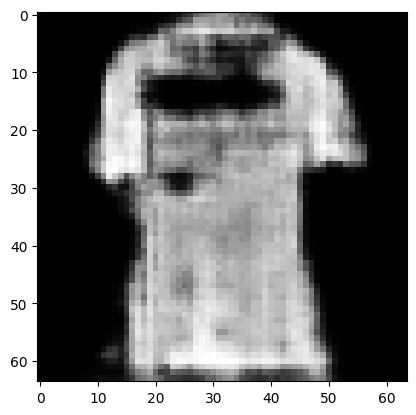

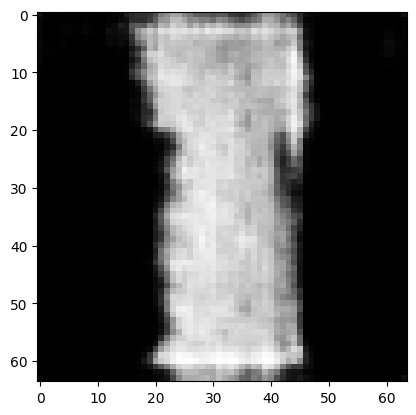

In [19]:
def inference(generator, latent_dims, label):
    z = torch.randn(1, latent_dims, 1, 1, device=device)
    one_hot_label = F.one_hot(torch.tensor([label]), num_classes=10).to(device).float()
    generated_image = generator(z, one_hot_label)
    plt.imshow(generated_image.cpu().detach().numpy().reshape(64, 64), cmap='gray')
    plt.show()

inference(generator, latent_dims, 0)
inference(generator, latent_dims, 3)

In [28]:
from torch import nn

latent_dims = 100

class DCGANGenerator(nn.Module):
    def __init__(self, base_filter_count):
        super().__init__()
        self.layers = nn.Sequential(
            # +10 for label information (conditional GAN)
            nn.ConvTranspose2d(latent_dims + 10, base_filter_count*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_filter_count*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*8, base_filter_count*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*4, base_filter_count*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*2, base_filter_count, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x)

class DCGANDiscriminator(nn.Module):
    def __init__(self, base_filter_count):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1 + 10, base_filter_count, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count, base_filter_count * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 2, base_filter_count * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 4, base_filter_count * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x).view(-1, 1).squeeze(1)



In [33]:
generator = DCGANGenerator(base_filter_count=64).to(device)
generator.apply(weight_initialization)

discriminator = DCGANDiscriminator(base_filter_count=64).to(device)
discriminator.apply(weight_initialization)

dcganA_generator_losses, dcganA_discriminator_losses = dcgan_train(discriminator, generator, fashion_mnist_data, 5)

torch.save(generator.state_dict(), 'dcgan_A_generator.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: 1.8076808452606201
Epoch: 0, Generator Loss: 1.120621681213379
Epoch: 0, Discriminator Loss: 1.3552607297897339
Epoch: 0, Generator Loss: 5.92374324798584
Epoch: 0, Discriminator Loss: 1.7703959941864014
Epoch: 0, Generator Loss: 1.2402763366699219
Epoch: 0, Discriminator Loss: 0.9704018831253052
Epoch: 0, Generator Loss: 3.3119871616363525
Epoch: 0, Discriminator Loss: 0.8477067947387695
Epoch: 0, Generator Loss: 3.1086947917938232
Epoch: 1, Discriminator Loss: 0.8371939659118652
Epoch: 1, Generator Loss: 1.9637832641601562
Epoch: 1, Discriminator Loss: 0.9715927243232727
Epoch: 1, Generator Loss: 1.8034610748291016
Epoch: 1, Discriminator Loss: 0.7473317384719849
Epoch: 1, Generator Loss: 2.122248888015747
Epoch: 1, Discriminator Loss: 0.7649606466293335
Epoch: 1, Generator Loss: 3.0818495750427246
Epoch: 1, Discriminator Loss: 0.7724745273590088
Epoch: 1, Generator Loss: 2.417386531829834
Epoch: 2, Discriminator Loss: 0.8500264286994934
Epoch: 2, Genera

In [34]:
generator = DCGANGenerator(base_filter_count=32).to(device)
generator.apply(weight_initialization)

discriminator = DCGANDiscriminator(base_filter_count=32).to(device)
discriminator.apply(weight_initialization)

dcganB_generator_losses, dcganB_discriminator_losses = dcgan_train(discriminator, generator, fashion_mnist_data, 5)

torch.save(generator.state_dict(), 'dcgan_B_generator.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: 1.604900598526001
Epoch: 0, Generator Loss: 0.9963231086730957
Epoch: 0, Discriminator Loss: 0.4125259518623352
Epoch: 0, Generator Loss: 2.567887783050537
Epoch: 0, Discriminator Loss: 0.48625749349594116
Epoch: 0, Generator Loss: 2.6301357746124268
Epoch: 0, Discriminator Loss: 0.6870574355125427
Epoch: 0, Generator Loss: 2.520141124725342
Epoch: 0, Discriminator Loss: 0.7611772418022156
Epoch: 0, Generator Loss: 2.323683261871338
Epoch: 1, Discriminator Loss: 0.7192952632904053
Epoch: 1, Generator Loss: 1.813262939453125
Epoch: 1, Discriminator Loss: 0.9092075228691101
Epoch: 1, Generator Loss: 2.089275598526001
Epoch: 1, Discriminator Loss: 1.1373342275619507
Epoch: 1, Generator Loss: 3.360884666442871
Epoch: 1, Discriminator Loss: 0.8190151453018188
Epoch: 1, Generator Loss: 1.83290433883667
Epoch: 1, Discriminator Loss: 0.885334849357605
Epoch: 1, Generator Loss: 1.6953948736190796
Epoch: 2, Discriminator Loss: 0.7690562009811401
Epoch: 2, Generator 

In [35]:
from functools import total_ordering
from tqdm.notebook import tqdm

def wgan_train(discriminator, generator, data, epochs):
    discriminatorOptimizer = torch.optim.RMSprop(discriminator.parameters(), lr=2e-4)
    generatorOptimizer = torch.optim.RMSprop(generator.parameters(), lr=2e-4)

    wc_limit = 0.01

    generator_losses = []
    discriminator_losses = []

    try:
        for epoch in tqdm(range(epochs)):
            epoch_generator_loss = 0
            epoch_discriminator_loss = 0
            for i, (x, y) in enumerate(data):
                # update discriminator
                # maximize log(D(x)) + log(1 - D(G(z)))
                x = x.to(device)
                y = F.one_hot(y, num_classes=10).to(device).float()
                discriminatorOptimizer.zero_grad()

                for p in discriminator.parameters():
                    p.data.clamp_(-wc_limit, wc_limit)

                real_preds = discriminator(x, y)
                real_loss = -torch.mean(real_preds)
                real_loss.backward()

                noise = torch.randn(x.shape[0], latent_dims, 1, 1, device=device)
                fake_images = generator(noise, y)
                fake_preds = discriminator(fake_images.detach(), y)
                fake_loss = torch.mean(fake_preds)
                fake_loss.backward()
                total_loss = real_loss + fake_loss

                discriminatorOptimizer.step()

                if i % 100 == 0:
                  print(f"Epoch: {epoch}, Discriminator Loss: {total_loss.item()}")
                epoch_discriminator_loss += total_loss.item()

                # update generator
                # maximize log(D(G(z)))
                generatorOptimizer.zero_grad()
                # ones because generator wants to generate "real" images
                fake_preds = discriminator(fake_images, y)
                generatorLoss = -torch.mean(fake_preds)
                generatorLoss.backward()
                generatorOptimizer.step()

                if i % 100 == 0:
                  print(f"Epoch: {epoch}, Generator Loss: {generatorLoss.item()}")
                epoch_generator_loss += generatorLoss.item()

            generator_losses.append(epoch_generator_loss / len(data))
            discriminator_losses.append(epoch_discriminator_loss / len(data))
    except KeyboardInterrupt:
        print("Exiting...")
    return generator_losses, discriminator_losses

In [36]:
from torch import nn

latent_dims = 100

class WGANGenerator(nn.Module):
    def __init__(self, base_filter_count):
        super().__init__()
        self.layers = nn.Sequential(
            # +10 for label information (conditional GAN)
            nn.ConvTranspose2d(latent_dims + 10, base_filter_count*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_filter_count*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*8, base_filter_count*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*4, base_filter_count*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*2, base_filter_count, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x)

class WGANDiscriminator(nn.Module):
    def __init__(self, base_filter_count):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1 + 10, base_filter_count, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count, base_filter_count * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 2, base_filter_count * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 4, base_filter_count * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x).view(-1, 1).squeeze(1)


In [37]:
generator = WGANGenerator(base_filter_count=64).to(device)
generator.apply(weight_initialization)

discriminator = WGANDiscriminator(base_filter_count=64).to(device)
discriminator.apply(weight_initialization)

wganA_generator_losses, wganA_discriminator_losses = wgan_train(discriminator, generator, fashion_mnist_data, 5)

torch.save(generator.state_dict(), 'wgan_A_generator.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: -0.0004281827714294195
Epoch: 0, Generator Loss: -0.0021037710830569267
Epoch: 0, Discriminator Loss: -0.0326559841632843
Epoch: 0, Generator Loss: 0.2067558616399765
Epoch: 0, Discriminator Loss: -0.1528545320034027
Epoch: 0, Generator Loss: 0.3812074065208435
Epoch: 0, Discriminator Loss: -0.1527366191148758
Epoch: 0, Generator Loss: 0.2865220308303833
Epoch: 0, Discriminator Loss: -0.17547784745693207
Epoch: 0, Generator Loss: 0.3609451949596405
Epoch: 1, Discriminator Loss: -0.12536509335041046
Epoch: 1, Generator Loss: 0.2893705368041992
Epoch: 1, Discriminator Loss: -0.31871476769447327
Epoch: 1, Generator Loss: 0.02143789641559124
Epoch: 1, Discriminator Loss: -0.3277653753757477
Epoch: 1, Generator Loss: 0.46330541372299194
Epoch: 1, Discriminator Loss: -0.3910967707633972
Epoch: 1, Generator Loss: 0.0307651087641716
Epoch: 1, Discriminator Loss: -0.46974074840545654
Epoch: 1, Generator Loss: 0.06111019849777222
Epoch: 2, Discriminator Loss: -0.366

<ipython-input-38-cbfc70a0e4d6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('wgan_A_generator.pth'))


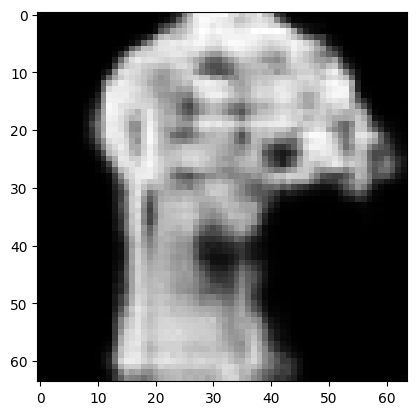

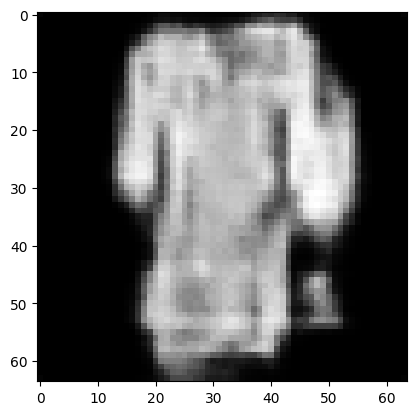

In [38]:
generator = WGANGenerator(base_filter_count=64).to(device)
generator.load_state_dict(torch.load('wgan_A_generator.pth'))

inference(generator, latent_dims, 0)
inference(generator, latent_dims, 3)

In [39]:
generator = WGANGenerator(base_filter_count=32).to(device)
generator.apply(weight_initialization)

discriminator = WGANDiscriminator(base_filter_count=32).to(device)
discriminator.apply(weight_initialization)

wganB_generator_losses, wganB_discriminator_losses = wgan_train(discriminator, generator, fashion_mnist_data, 5)

torch.save(generator.state_dict(), 'wgan_B_generator.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: 7.583654951304197e-05
Epoch: 0, Generator Loss: -0.006070706062018871
Epoch: 0, Discriminator Loss: -0.06338338553905487
Epoch: 0, Generator Loss: 0.2310732901096344
Epoch: 0, Discriminator Loss: -0.0754852145910263
Epoch: 0, Generator Loss: -0.07190841436386108
Epoch: 0, Discriminator Loss: -0.07611697912216187
Epoch: 0, Generator Loss: 0.05768422782421112
Epoch: 0, Discriminator Loss: -0.0711202621459961
Epoch: 0, Generator Loss: 0.00289367139339447
Epoch: 1, Discriminator Loss: -0.05653300881385803
Epoch: 1, Generator Loss: 0.0044121635146439075
Epoch: 1, Discriminator Loss: -0.04854874312877655
Epoch: 1, Generator Loss: 0.1357012391090393
Epoch: 1, Discriminator Loss: -0.0722694993019104
Epoch: 1, Generator Loss: 0.05131077021360397
Epoch: 1, Discriminator Loss: -0.07124476879835129
Epoch: 1, Generator Loss: -0.064389169216156
Epoch: 1, Discriminator Loss: -0.07366156578063965
Epoch: 1, Generator Loss: 0.14607371389865875
Epoch: 2, Discriminator Loss: 

<ipython-input-40-9e877c3e51be>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('wgan_B_generator.pth'))


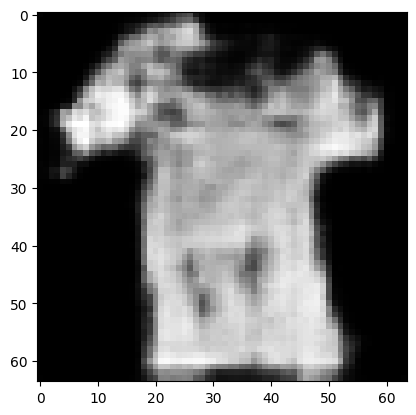

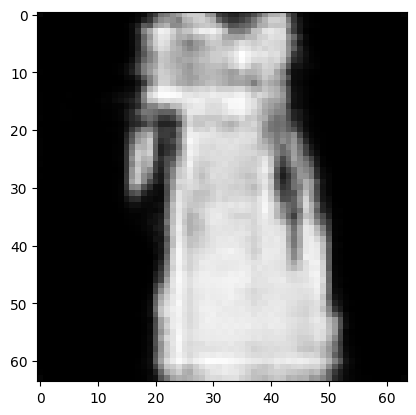

In [40]:
generator = WGANGenerator(base_filter_count=32).to(device)
generator.load_state_dict(torch.load('wgan_B_generator.pth'))

inference(generator, latent_dims, 0)
inference(generator, latent_dims, 3)

In [15]:
from functools import total_ordering
from tqdm.notebook import tqdm

def wgangp_train(discriminator, generator, data, epochs):
    discriminatorOptimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    generatorOptimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    _lambda = 10

    generator_losses = []
    discriminator_losses = []

    try:
        for epoch in tqdm(range(epochs)):
            epoch_generator_loss = 0
            epoch_discriminator_loss = 0
            for i, (x, y) in enumerate(data):
                # update discriminator
                # maximize log(D(x)) + log(1 - D(G(z)))
                x = x.to(device)
                y = F.one_hot(y, num_classes=10).to(device).float()
                discriminatorOptimizer.zero_grad()
                real_preds = discriminator(x, y)
                real_loss = -torch.mean(real_preds)
                real_loss.backward()

                noise = torch.randn(x.shape[0], latent_dims, 1, 1, device=device)
                fake_images = generator(noise, y)
                fake_preds = discriminator(fake_images.detach(), y)
                fake_loss = torch.mean(fake_preds)
                fake_loss.backward()
                total_loss = real_loss + fake_loss

                # gradient penalty
                epsilon = torch.rand(x.shape[0], 1, 1, 1, device=device)
                interpolated_images = epsilon * x.data + (1 - epsilon) * fake_images.data
                interpolated_images = torch.autograd.Variable(interpolated_images, requires_grad=True)
                interpolated_preds = discriminator(interpolated_images, y)
                gradient = torch.autograd.grad(outputs=interpolated_preds, inputs=interpolated_images,
                                              grad_outputs=torch.ones(interpolated_preds.size()).to(device),
                                              create_graph=True, retain_graph=True, only_inputs=True)[0]
                gradient = gradient.view(x.shape[0], -1)
                gradient_norm = torch.norm(gradient, 2, 1)
                gradient_penalty = _lambda * torch.mean((gradient_norm - 1) ** 2)
                gradient_penalty.backward()
                total_loss += gradient_penalty

                discriminatorOptimizer.step()

                if i % 100 == 0:
                  print(f"Epoch: {epoch}, Discriminator Loss: {total_loss.item()}")
                epoch_discriminator_loss += total_loss.item()

                # update generator
                # maximize log(D(G(z)))
                generatorOptimizer.zero_grad()
                # ones because generator wants to generate "real" images
                fake_preds = discriminator(fake_images, y)
                generatorLoss = -torch.mean(fake_preds)
                generatorLoss.backward()
                generatorOptimizer.step()

                if i % 100 == 0:
                  print(f"Epoch: {epoch}, Generator Loss: {generatorLoss.item()}")
                epoch_generator_loss += generatorLoss.item()

            generator_losses.append(epoch_generator_loss / len(data))
            discriminator_losses.append(epoch_discriminator_loss / len(data))
    except KeyboardInterrupt:
        print("Exiting...")
    return generator_losses, discriminator_losses

In [10]:
from torch import nn

latent_dims = 100

class WGANGPGenerator(nn.Module):
    def __init__(self, base_filter_count):
        super().__init__()
        self.layers = nn.Sequential(
            # +10 for label information (conditional GAN)
            nn.ConvTranspose2d(latent_dims + 10, base_filter_count*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_filter_count*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*8, base_filter_count*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*4, base_filter_count*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count*2, base_filter_count, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_filter_count),
            nn.ReLU(True),

            nn.ConvTranspose2d(base_filter_count, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x)

class WGANGPDiscriminator(nn.Module):
    def __init__(self, base_filter_count):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1 + 10, base_filter_count, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count, base_filter_count * 2, 4, 2, 1, bias=False),
            # nn.LayerNorm(base_filter_count * 2),
            nn.InstanceNorm2d(base_filter_count * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 2, base_filter_count * 4, 4, 2, 1, bias=False),
            # nn.LayerNorm(base_filter_count * 4),
            nn.InstanceNorm2d(base_filter_count * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 4, base_filter_count * 8, 4, 2, 1, bias=False),
            # nn.LayerNorm(base_filter_count * 8),
            nn.InstanceNorm2d(base_filter_count * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_filter_count * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x, labels):
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        labels = labels.repeat(1, 1, x.shape[2], x.shape[3])
        x = torch.cat((x, labels), dim=1)
        return self.layers(x).view(-1, 1).squeeze(1)


In [16]:
generator = WGANGPGenerator(base_filter_count=64).to(device)
generator.apply(weight_initialization)

discriminator = WGANGPDiscriminator(base_filter_count=64).to(device)
discriminator.apply(weight_initialization)

wgangpA_generator_losses, wgangpA_discriminator_losses = wgangp_train(discriminator, generator, fashion_mnist_data, 5)

torch.save(generator.state_dict(), 'wgan_gp_A_generator.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: 365.4768371582031
Epoch: 0, Generator Loss: 1.5156712532043457
Epoch: 0, Discriminator Loss: -6.883376121520996
Epoch: 0, Generator Loss: 5.758906364440918
Epoch: 0, Discriminator Loss: -7.962987899780273
Epoch: 0, Generator Loss: 11.749496459960938
Epoch: 0, Discriminator Loss: -7.496118545532227
Epoch: 0, Generator Loss: 15.44859790802002
Epoch: 0, Discriminator Loss: -4.223422050476074
Epoch: 0, Generator Loss: 10.22480583190918
Epoch: 1, Discriminator Loss: -3.8589632511138916
Epoch: 1, Generator Loss: 13.24649429321289
Epoch: 1, Discriminator Loss: -3.458585023880005
Epoch: 1, Generator Loss: 7.245616912841797
Epoch: 1, Discriminator Loss: -4.05993127822876
Epoch: 1, Generator Loss: 11.700982093811035
Epoch: 1, Discriminator Loss: -4.419233322143555
Epoch: 1, Generator Loss: 17.073562622070312
Epoch: 1, Discriminator Loss: -4.488574504852295
Epoch: 1, Generator Loss: 13.636674880981445
Epoch: 2, Discriminator Loss: -2.913569450378418
Epoch: 2, Generat

<ipython-input-23-20a828ba454e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('wgan_gp_A_generator.pth'))


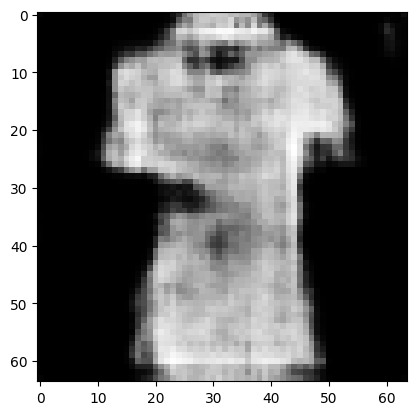

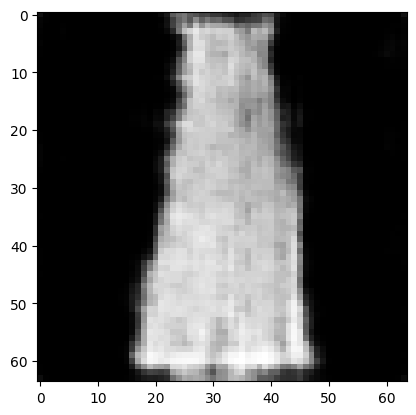

In [23]:
generator = WGANGPGenerator(base_filter_count=64).to(device)
generator.load_state_dict(torch.load('wgan_gp_A_generator.pth'))

inference(generator, latent_dims, 0)
inference(generator, latent_dims, 3)

In [24]:
generator = WGANGPGenerator(base_filter_count=32).to(device)
generator.apply(weight_initialization)

discriminator = WGANGPDiscriminator(base_filter_count=32).to(device)
discriminator.apply(weight_initialization)

wgangpB_generator_losses, wgangpB_discriminator_losses = wgangp_train(discriminator, generator, fashion_mnist_data, 5)

torch.save(generator.state_dict(), 'wgan_gp_B_generator.pth')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Discriminator Loss: 249.7655792236328
Epoch: 0, Generator Loss: -0.6305446624755859
Epoch: 0, Discriminator Loss: -8.51806640625
Epoch: 0, Generator Loss: 6.763260841369629
Epoch: 0, Discriminator Loss: -10.129999160766602
Epoch: 0, Generator Loss: 6.594407081604004
Epoch: 0, Discriminator Loss: -5.283559322357178
Epoch: 0, Generator Loss: 7.012096881866455
Epoch: 0, Discriminator Loss: -3.8956966400146484
Epoch: 0, Generator Loss: 3.9740090370178223
Epoch: 1, Discriminator Loss: -1.8821039199829102
Epoch: 1, Generator Loss: 9.291836738586426
Epoch: 1, Discriminator Loss: -3.1435189247131348
Epoch: 1, Generator Loss: 8.436063766479492
Epoch: 1, Discriminator Loss: -2.499525308609009
Epoch: 1, Generator Loss: 4.610074043273926
Epoch: 1, Discriminator Loss: -2.1906204223632812
Epoch: 1, Generator Loss: 3.859293222427368
Epoch: 1, Discriminator Loss: -2.6013591289520264
Epoch: 1, Generator Loss: -0.16991668939590454
Epoch: 2, Discriminator Loss: -2.099278211593628
Epoch: 2, Gene

<ipython-input-26-027ec4715177>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('wgan_gp_B_generator.pth'))


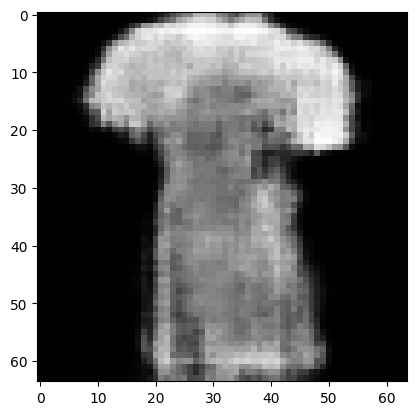

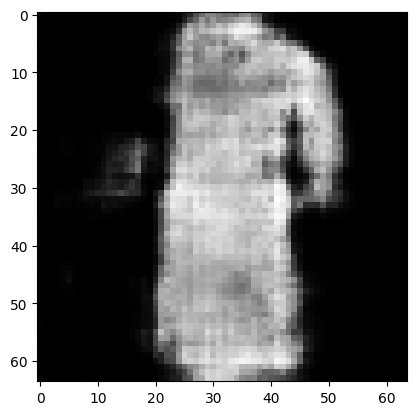

In [26]:
generator = WGANGPGenerator(base_filter_count=32).to(device)
generator.load_state_dict(torch.load('wgan_gp_B_generator.pth'))

inference(generator, latent_dims, 0)
inference(generator, latent_dims, 3)

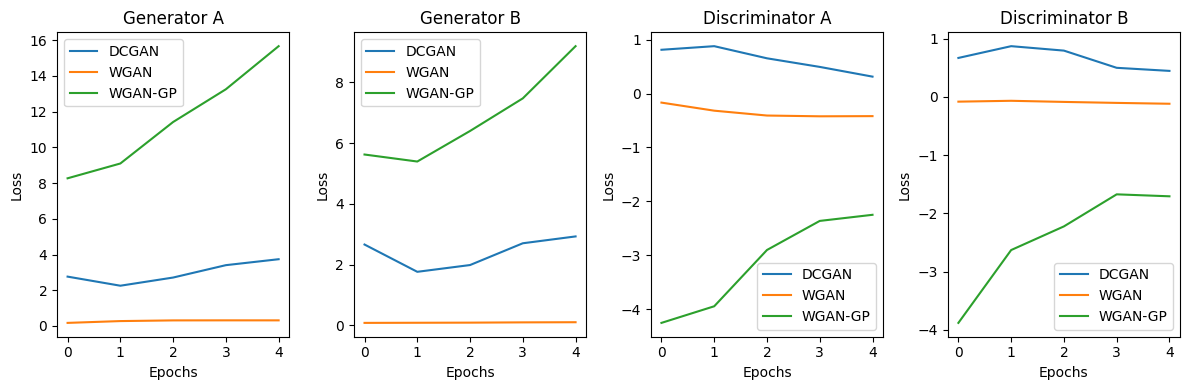

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.title('Generator A')
plt.plot(dcganA_generator_losses, label='DCGAN')
plt.plot(wganA_generator_losses, label='WGAN')
plt.plot(wgangpA_generator_losses, label='WGAN-GP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 2)
plt.title('Generator B')
plt.plot(dcganB_generator_losses, label='DCGAN')
plt.plot(wganB_generator_losses, label='WGAN')
plt.plot(wgangpB_generator_losses, label='WGAN-GP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 3)
plt.title('Discriminator A')
plt.plot(dcganA_discriminator_losses, label='DCGAN')
plt.plot(wganA_discriminator_losses, label='WGAN')
plt.plot(wgangpA_discriminator_losses, label='WGAN-GP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 4, 4)
plt.title('Discriminator B')
plt.plot(dcganB_discriminator_losses, label='DCGAN')
plt.plot(wganB_discriminator_losses, label='WGAN')
plt.plot(wgangpB_discriminator_losses, label='WGAN-GP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-43-6aca22f40b0d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_dcgan_A.load_state_dict(torch.load('dcgan_A_generator.pth'))
<ipython-input-43-6ac

Generating T-Shirt Images for Architecture A


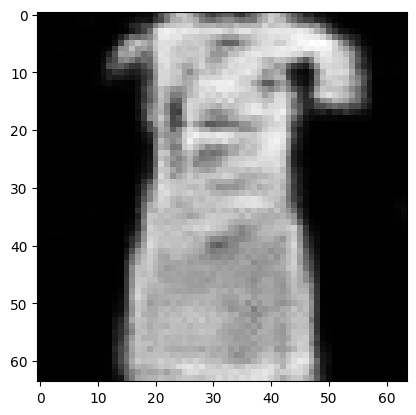

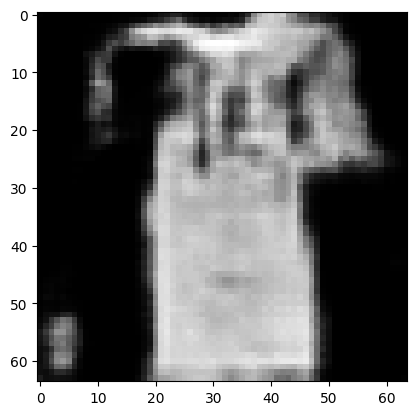

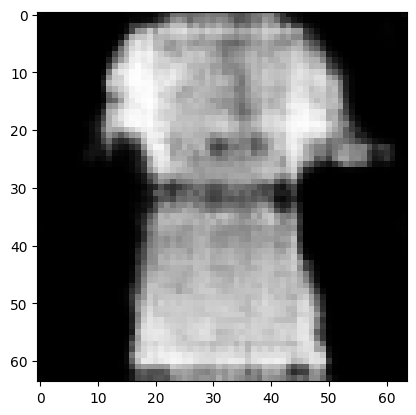

Generating Dress Images for Architecture A


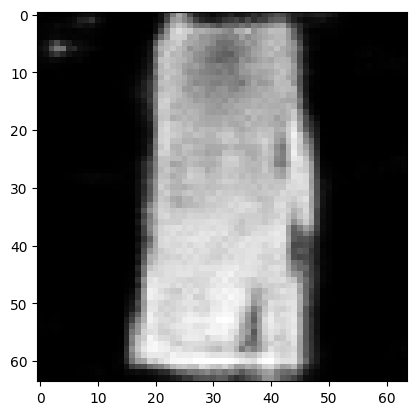

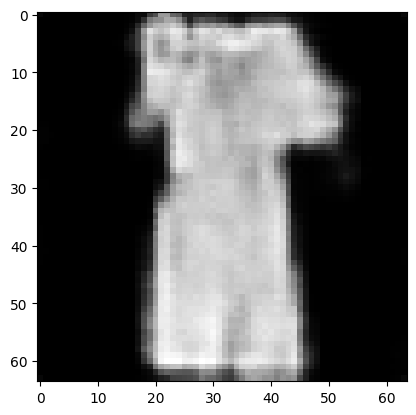

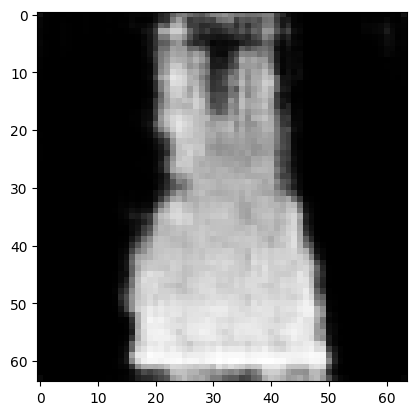

In [43]:
generator_dcgan_A = DCGANGenerator(base_filter_count=64).to(device)
generator_dcgan_A.load_state_dict(torch.load('dcgan_A_generator.pth'))
generator_wgan_A = WGANGenerator(base_filter_count=64).to(device)
generator_wgan_A.load_state_dict(torch.load('wgan_A_generator.pth'))
generator_wgangp_A = WGANGPGenerator(base_filter_count=64).to(device)
generator_wgangp_A.load_state_dict(torch.load('wgan_gp_A_generator.pth'))

print("Generating T-Shirt Images for Architecture A")
inference(generator_dcgan_A, latent_dims, 0)
inference(generator_wgan_A, latent_dims, 0)
inference(generator_wgangp_A, latent_dims, 0)

print("Generating Dress Images for Architecture A")
inference(generator_dcgan_A, latent_dims, 3)
inference(generator_wgan_A, latent_dims, 3)
inference(generator_wgangp_A, latent_dims, 3)


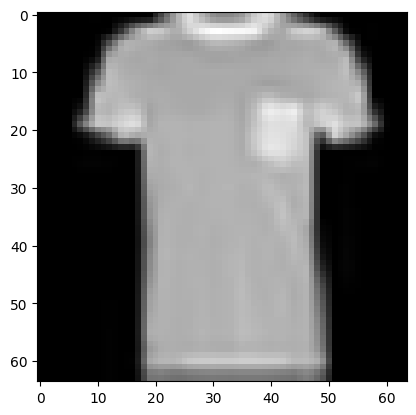

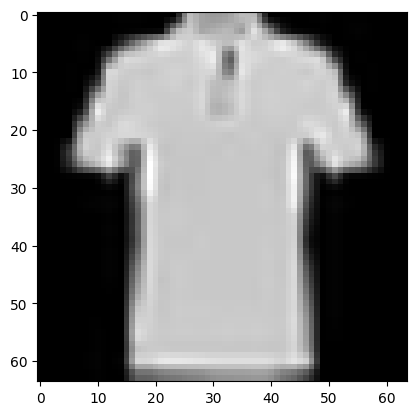

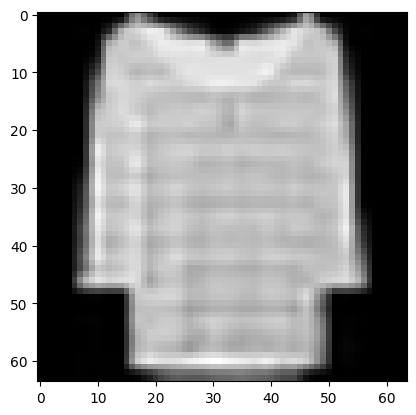

In [51]:
n = 3
i = 0
for x, y in fashion_mnist_data:
    if i == n:
        break
    if y[0].item() == 0:
        plt.imshow(x[0].reshape(64, 64), cmap='gray')
        i += 1
        continue
    plt.show()

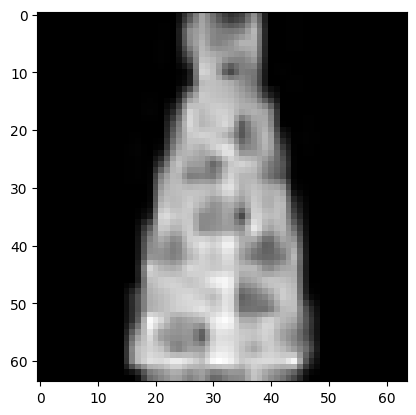

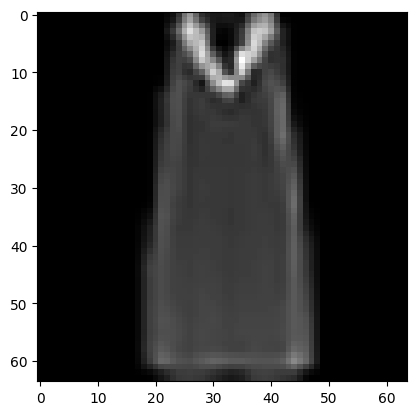

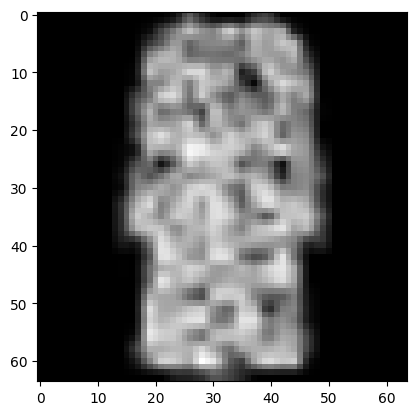

In [52]:
n = 3
i = 0
for x, y in fashion_mnist_data:
    if i == n:
        break
    if y[0].item() == 3:
        plt.imshow(x[0].reshape(64, 64), cmap='gray')
        i += 1
        continue
    plt.show()